In [1]:
# Dự án: Nén ảnh sử dụng PCA và Autoencoders
#  — cell 1: imports và cấu hình
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Cấu hình matplotlib để hiển thị ảnh đẹp hơn
plt.style.use('default')
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

2025-12-17 06:37:18.254284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765953438.440260      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765953438.500498      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
Keras version: 3.8.0


Loading Cats vs Dogs dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1765953460.677798      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765953460.678440      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 ext

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.6QPCUQ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Data: 10000 train (fit), 1500 test (eval)


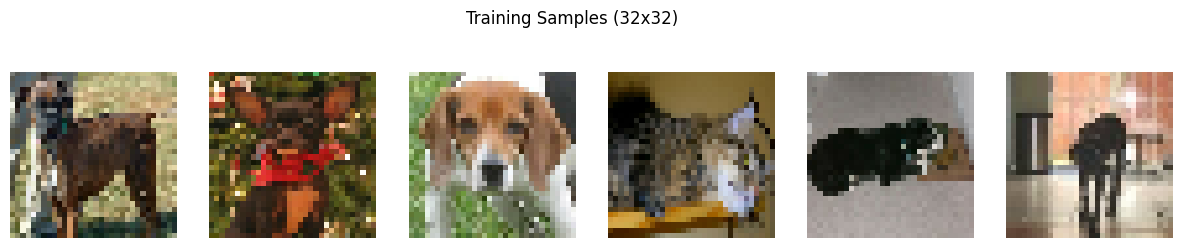

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print('Loading Cats vs Dogs dataset...')

(ds_train, ds_test), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:85%]', 'train[85%:]'], 
    with_info=True,
    as_supervised=True
)

class Config:
    IMG_SIZE = 32
    BATCH_SIZE = 32
    NUM_TRAIN = 10000
    NUM_TEST  = 1500
cfg = Config()

def preprocess(image, label, augment=False):
    image = tf.image.resize(image, [cfg.IMG_SIZE, cfg.IMG_SIZE])
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.cast(image, tf.float32) / 255.0
    return tf.clip_by_value(image, 0.0, 1.0)

train_dataset = (
    ds_train.take(cfg.NUM_TRAIN)
    .map(lambda x, y: preprocess(x, y, False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(cfg.BATCH_SIZE)
    .map(lambda x: (x, x))
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    ds_test.take(cfg.NUM_TEST)
    .map(lambda x, y: preprocess(x, y, False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(cfg.BATCH_SIZE)
    .map(lambda x: (x, x))
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Data: {cfg.NUM_TRAIN} train (fit), {cfg.NUM_TEST} test (eval)")

# Show samples
samples = next(iter(train_dataset))[0].numpy()[:6]
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.suptitle(f'Training Samples ({cfg.IMG_SIZE}x{cfg.IMG_SIZE})')
plt.show()

In [3]:
import numpy as np

def dataset_to_numpy(dataset, num_images):
    out = []
    count = 0
    for batch in dataset:
        imgs = batch[0].numpy()   # dataset đang là (x,x)
        out.append(imgs)
        count += imgs.shape[0]
        if count >= num_images:
            break
    return np.concatenate(out, axis=0)[:num_images]

# FIT PCA trên train
images_train = dataset_to_numpy(train_dataset, cfg.NUM_TRAIN)

# ĐÁNH GIÁ trên test
images_test  = dataset_to_numpy(test_dataset,  cfg.NUM_TEST)

print("images_train:", images_train.shape)
print("images_test :", images_test.shape)

images_train: (10000, 32, 32, 3)
images_test : (1500, 32, 32, 3)


In [4]:
# Section 4: PCA tự xây dựng sử dụng SVD (Singular Value Decomposition)
class CustomPCA:
    def __init__(self, n_components=500):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.singular_values = None
        self.explained_variance = None
        self.explained_variance_ratio = None

    def fit(self, X):
        # Step 1: Tính mean và center data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Step 2: SVD decomposition (full_matrices=False để tiết kiệm bộ nhớ)
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

        # Step 3: Principal components là các hàng của V^T
        self.components = Vt[:self.n_components]  # Shape: (n_components, n_features)
        self.singular_values = S[:self.n_components]

        # Step 4: Tính explained variance
        explained_variance = (S ** 2) / (X.shape[0] - 1)
        self.explained_variance = explained_variance[:self.n_components]
        self.explained_variance_ratio = self.explained_variance / np.sum(explained_variance)

        return self

    def get_cumulative_variance_ratio(self):
        return np.cumsum(self.explained_variance_ratio)

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)

    def inverse_transform(self, X_transformed):
        X_reconstructed = np.dot(X_transformed, self.components)
        return X_reconstructed + self.mean


class PCAImageCompressor:
    def __init__(self, n_components=500):
        self.n_components = n_components
        self.pca_r = CustomPCA(n_components=n_components)
        self.pca_g = CustomPCA(n_components=n_components)
        self.pca_b = CustomPCA(n_components=n_components)
        self.img_shape = None

    def fit(self, images):
        print(f"Đang huấn luyện CustomPCA (tự xây dựng với SVD) với {self.n_components} components...")
        self.img_shape = images.shape[1:]
        n_samples, h, w = images.shape[0], images.shape[1], images.shape[2]

        # Reshape từng kênh màu thành ma trận 2D
        r_channel = images[:, :, :, 0].reshape(n_samples, -1)
        g_channel = images[:, :, :, 1].reshape(n_samples, -1)
        b_channel = images[:, :, :, 2].reshape(n_samples, -1)

        print(f"  Shape mỗi kênh: {r_channel.shape}")
        print(f"  Tỷ lệ n_samples/n_features = {n_samples}/{h*w} = {n_samples/(h*w):.4f}")

        # Huấn luyện từng kênh
        self.pca_r.fit(r_channel)
        self.pca_g.fit(g_channel)
        self.pca_b.fit(b_channel)

        # Tính variance cho từng kênh
        var_r = np.sum(self.pca_r.explained_variance_ratio)
        var_g = np.sum(self.pca_g.explained_variance_ratio)
        var_b = np.sum(self.pca_b.explained_variance_ratio)

        print(f"✓ PCA đã được huấn luyện!")
        print(f"Variance được giữ lại:")
        print(f"  - Kênh R: {var_r:.4f} ({var_r*100:.2f}%)")
        print(f"  - Kênh G: {var_g:.4f} ({var_g*100:.2f}%)")
        print(f"  - Kênh B: {var_b:.4f} ({var_b*100:.2f}%)")

    def compress(self, images):
        n_samples = images.shape[0]
        r_channel = images[:, :, :, 0].reshape(n_samples, -1)
        g_channel = images[:, :, :, 1].reshape(n_samples, -1)
        b_channel = images[:, :, :, 2].reshape(n_samples, -1)

        r_compressed = self.pca_r.transform(r_channel)
        g_compressed = self.pca_g.transform(g_channel)
        b_compressed = self.pca_b.transform(b_channel)

        return r_compressed, g_compressed, b_compressed

    def decompress(self, r_compressed, g_compressed, b_compressed):
        r_decompressed = self.pca_r.inverse_transform(r_compressed)
        g_decompressed = self.pca_g.inverse_transform(g_compressed)
        b_decompressed = self.pca_b.inverse_transform(b_compressed)

        n_samples = r_compressed.shape[0]
        h, w, c = self.img_shape

        # Tái tạo ảnh 4D từ các kênh đã khôi phục
        images_out = np.zeros((n_samples, h, w, 3), dtype=np.float32)
        images_out[:, :, :, 0] = r_decompressed.reshape(n_samples, h, w)
        images_out[:, :, :, 1] = g_decompressed.reshape(n_samples, h, w)
        images_out[:, :, :, 2] = b_decompressed.reshape(n_samples, h, w)

        # Clip giá trị về [0, 1]
        images_out = np.clip(images_out, 0, 1)

        return images_out

    def get_compression_ratio(self):
        h, w, c = self.img_shape
        original_size = h * w * c
        compressed_size = self.n_components * 3 
        return original_size / compressed_size


# Thử nghiệm PCA với các số lượng components khác nhau
# 830
print("=" * 70)
print("NÉN ẢNH VỚI CustomPCA (SVD - Tự xây dựng)")
print("=" * 70)

n_components_list = [200, 300, 400]
pca_results = {}

for n_comp in n_components_list:
    pca_compressor = PCAImageCompressor(n_components=n_comp)

    # Fit trên train
    pca_compressor.fit(images_train)

    # Reconstruct trên test (ví dụ lấy 50 ảnh test để nhanh)
    X_eval = images_test[:50]
    r_comp, g_comp, b_comp = pca_compressor.compress(X_eval)
    reconstructed = pca_compressor.decompress(r_comp, g_comp, b_comp)

    ratio = pca_compressor.get_compression_ratio()

    pca_results[n_comp] = {
        "compressor": pca_compressor,
        "reconstructed": reconstructed,
        "ratio": ratio,
        "X_eval": X_eval
    }


NÉN ẢNH VỚI CustomPCA (SVD - Tự xây dựng)
Đang huấn luyện CustomPCA (tự xây dựng với SVD) với 200 components...
  Shape mỗi kênh: (10000, 1024)
  Tỷ lệ n_samples/n_features = 10000/1024 = 9.7656
✓ PCA đã được huấn luyện!
Variance được giữ lại:
  - Kênh R: 0.8911 (89.11%)
  - Kênh G: 0.8877 (88.77%)
  - Kênh B: 0.8908 (89.08%)
Đang huấn luyện CustomPCA (tự xây dựng với SVD) với 300 components...
  Shape mỗi kênh: (10000, 1024)
  Tỷ lệ n_samples/n_features = 10000/1024 = 9.7656
✓ PCA đã được huấn luyện!
Variance được giữ lại:
  - Kênh R: 0.9201 (92.01%)
  - Kênh G: 0.9174 (91.74%)
  - Kênh B: 0.9198 (91.98%)
Đang huấn luyện CustomPCA (tự xây dựng với SVD) với 400 components...
  Shape mỗi kênh: (10000, 1024)
  Tỷ lệ n_samples/n_features = 10000/1024 = 9.7656
✓ PCA đã được huấn luyện!
Variance được giữ lại:
  - Kênh R: 0.9406 (94.06%)
  - Kênh G: 0.9384 (93.84%)
  - Kênh B: 0.9402 (94.02%)



ĐÁNH GIÁ CHẤT LƯỢNG NÉN (MSE + SSIM + PSNR)
 200 components | MSE=0.006287±0.002416 | SSIM=0.7980±0.0490 | PSNR=22.34±1.71 dB
 300 components | MSE=0.004755±0.001890 | SSIM=0.8463±0.0394 | PSNR=23.57±1.75 dB
 400 components | MSE=0.003680±0.001487 | SSIM=0.8802±0.0333 | PSNR=24.69±1.77 dB


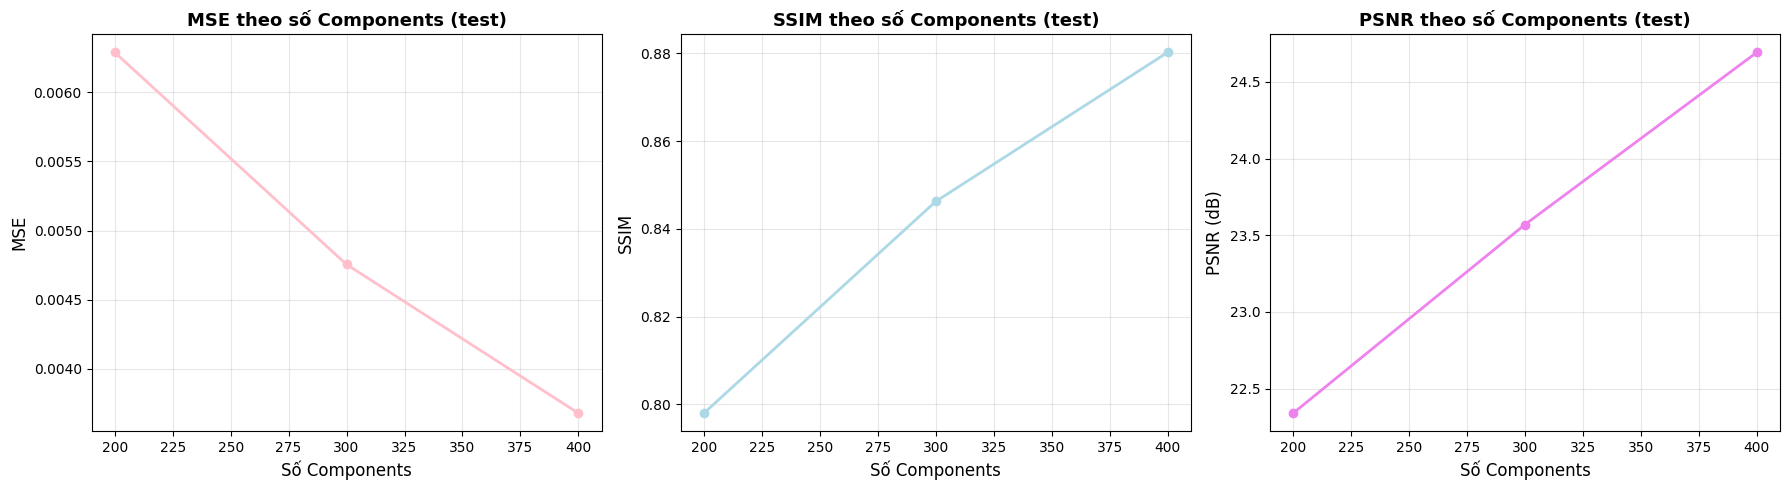

In [5]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("ĐÁNH GIÁ CHẤT LƯỢNG NÉN (MSE + SSIM + PSNR)")
print("="*60)

quality_results = {}

for n_comp in n_components_list:
    X_eval = pca_results[n_comp]["X_eval"]             
    reconstructed = pca_results[n_comp]["reconstructed"]

    mse_scores  = []
    ssim_scores = []
    psnr_scores = []

    for i in range(len(X_eval)):
        # MSE per-image
        mse_i = np.mean((X_eval[i] - reconstructed[i]) ** 2)
        mse_scores.append(mse_i)

        # SSIM / PSNR from skimage
        ssim_i = ssim(X_eval[i], reconstructed[i], channel_axis=-1, data_range=1.0)
        psnr_i = psnr(X_eval[i], reconstructed[i], data_range=1.0)

        ssim_scores.append(ssim_i)
        psnr_scores.append(psnr_i)

    quality_results[n_comp] = {
        "mse_mean":  float(np.mean(mse_scores)),
        "mse_std":   float(np.std(mse_scores)),
        "ssim_mean": float(np.mean(ssim_scores)),
        "ssim_std":  float(np.std(ssim_scores)),
        "psnr_mean": float(np.mean(psnr_scores)),
        "psnr_std":  float(np.std(psnr_scores)),
    }

    print(f"{n_comp:4d} components | "
          f"MSE={quality_results[n_comp]['mse_mean']:.6f}±{quality_results[n_comp]['mse_std']:.6f} | "
          f"SSIM={quality_results[n_comp]['ssim_mean']:.4f}±{quality_results[n_comp]['ssim_std']:.4f} | "
          f"PSNR={quality_results[n_comp]['psnr_mean']:.2f}±{quality_results[n_comp]['psnr_std']:.2f} dB")

# ===== Plot (mean) =====
components = list(quality_results.keys())
mse_values  = [quality_results[c]['mse_mean'] for c in components]
ssim_values = [quality_results[c]['ssim_mean'] for c in components]
psnr_values = [quality_results[c]['psnr_mean'] for c in components]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(components, mse_values, marker='o', linewidth=2, color='pink')
ax1.set_xlabel('Số Components', fontsize=12)
ax1.set_ylabel('MSE', fontsize=12)
ax1.set_title('MSE theo số Components (test)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(components, ssim_values, marker='o', linewidth=2, color='lightblue')
ax2.set_xlabel('Số Components', fontsize=12)
ax2.set_ylabel('SSIM', fontsize=12)
ax2.set_title('SSIM theo số Components (test)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3.plot(components, psnr_values, marker='o', linewidth=2, color='violet')
ax3.set_xlabel('Số Components', fontsize=12)
ax3.set_ylabel('PSNR (dB)', fontsize=12)
ax3.set_title('PSNR theo số Components (test)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


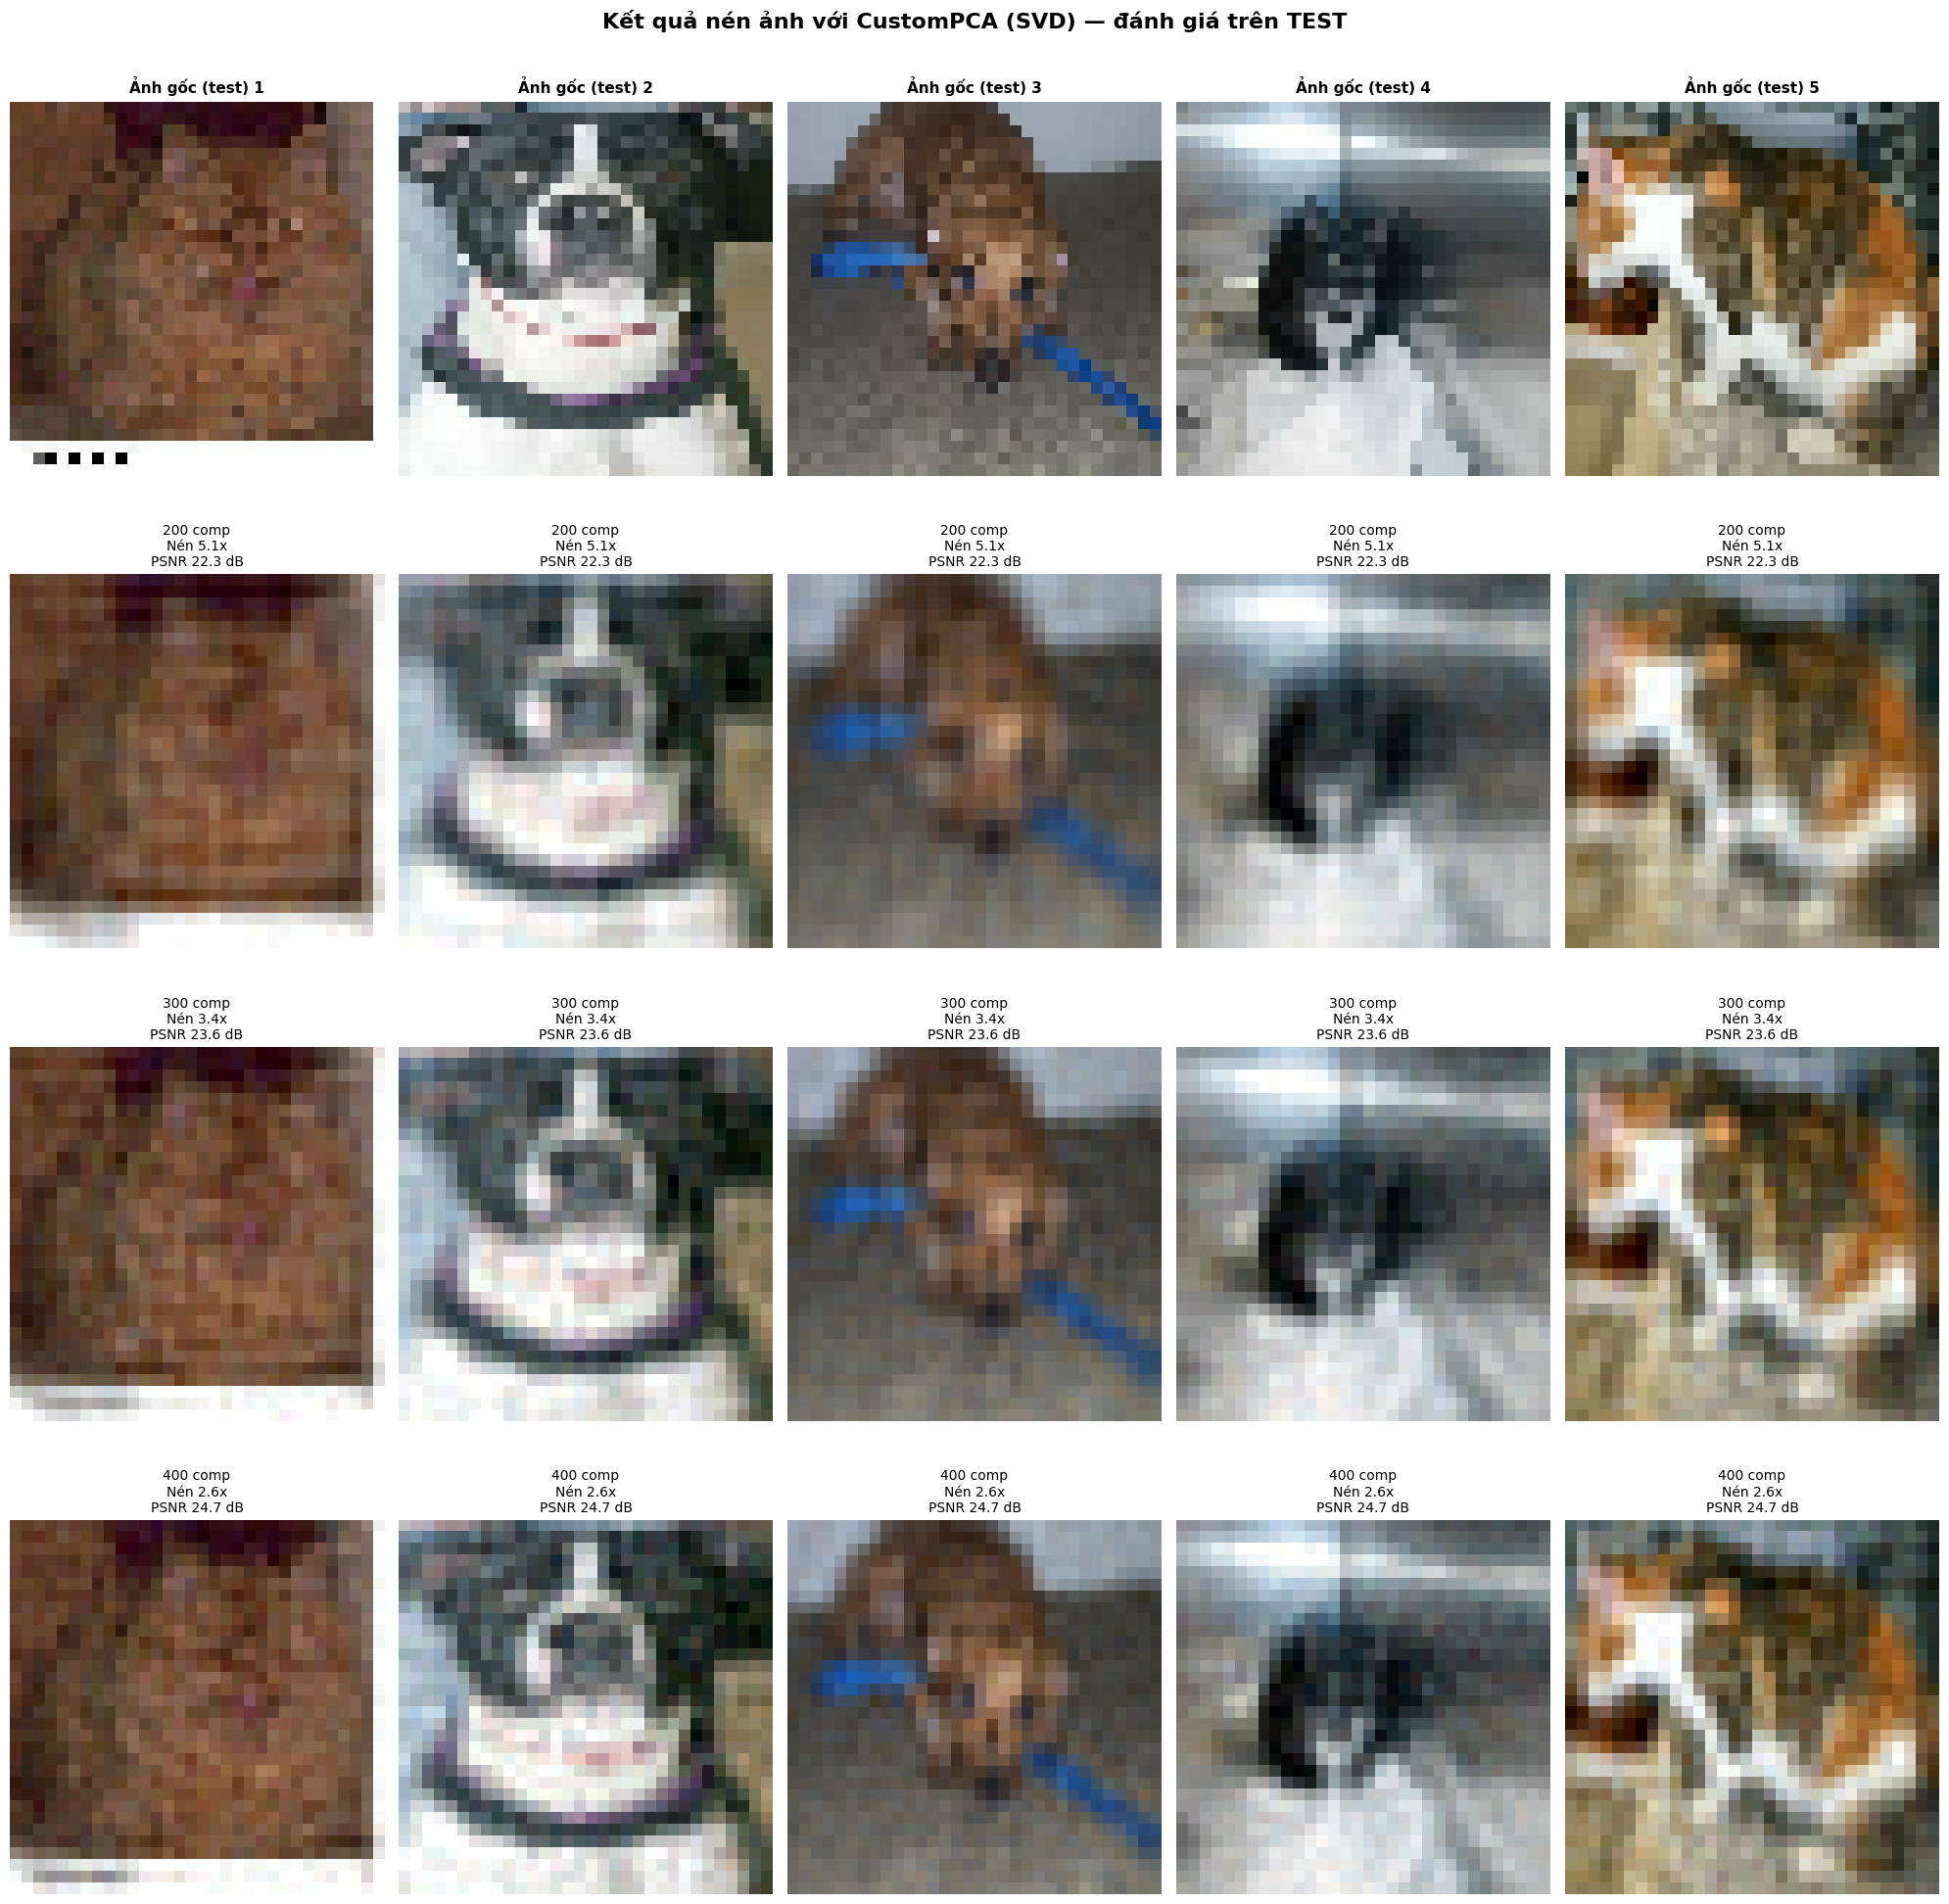

In [6]:
# Lấy tập ảnh gốc dùng để eval (test) — đảm bảo đồng nhất cho mọi hàng
X_eval = pca_results[n_components_list[0]]['X_eval']

fig, axes = plt.subplots(len(n_components_list) + 1, 5,
                         figsize=(20, 5*(len(n_components_list)+1)))

# Hàng đầu tiên: ảnh gốc (TEST)
for i in range(5):
    axes[0, i].imshow(X_eval[i])
    axes[0, i].set_title(f'Ảnh gốc (test) {i+1}', fontsize=11, fontweight='bold')
    axes[0, i].axis('off')

# Các hàng tiếp theo: kết quả nén với các components khác nhau
for row, n_comp in enumerate(n_components_list, 1):
    reconstructed = pca_results[n_comp]['reconstructed']  # recon của X_eval
    ratio = pca_results[n_comp]['ratio']
    psnr = quality_results[n_comp]['psnr_mean']  # PSNR trung bình (batch)

    for i in range(5):
        axes[row, i].imshow(reconstructed[i])
        axes[row, i].set_title(f'{n_comp} comp\nNén {ratio:.1f}x\nPSNR {psnr:.1f} dB',
                               fontsize=10)
        axes[row, i].axis('off')

plt.suptitle('Kết quả nén ảnh với CustomPCA (SVD) — đánh giá trên TEST',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [7]:
# ===== Visualization: SSIM & PSNR Distribution (đồng bộ TEST) =====
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Lấy đúng tập eval (TEST) đã dùng trong PCA loop
X_eval = pca_results[n_components_list[0]]["X_eval"]   # (N_eval, H, W, 3)
N_eval = len(X_eval)

ssim_list, psnr_list = [], []

for i in range(N_eval):
    orig = X_eval[i]
    for n_comp in n_components_list:
        recon = pca_results[n_comp]['reconstructed'][i]  # recon của đúng X_eval
        ssim_val = ssim(orig, recon, channel_axis=-1, data_range=1.0)
        psnr_val = calculate_psnr(orig, recon, max_value=1.0)
        ssim_list.append(ssim_val)
        psnr_list.append(psnr_val)

ssim_arr = np.array(ssim_list)
psnr_arr = np.array(psnr_list)

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.hist(ssim_arr, bins=20, color='pink', edgecolor='black', alpha=0.7)
plt.title(f'SSIM Histogram (test, N={N_eval})')
plt.xlabel('SSIM')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(psnr_arr, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
plt.title(f'PSNR Histogram (test, N={N_eval})')
plt.xlabel('PSNR (dB)')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.scatter(ssim_arr, psnr_arr, color='blue', alpha=0.6)
plt.xlabel('SSIM')
plt.ylabel('PSNR (dB)')
plt.title('SSIM vs PSNR (test)')

plt.tight_layout()
plt.show()

NameError: name 'calculate_psnr' is not defined

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# dùng đúng tập eval (TEST) đã lưu trong pca_results
X_eval = pca_results[n_components_list[0]]["X_eval"]
N_eval = len(X_eval)

ssim_by_class = defaultdict(list)
psnr_by_class = defaultdict(list)

for i in range(N_eval):
    orig = X_eval[i]
    for n_comp in n_components_list:
        recon = pca_results[n_comp]['reconstructed'][i]
        ssim_val = ssim(orig, recon, channel_axis=-1, data_range=1.0)
        psnr_val = calculate_psnr(orig, recon, max_value=1.0)
        ssim_by_class[n_comp].append(ssim_val)
        psnr_by_class[n_comp].append(psnr_val)

avg_ssim = [float(np.mean(ssim_by_class[nc])) for nc in n_components_list]
avg_psnr = [float(np.mean(psnr_by_class[nc])) for nc in n_components_list]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(n_components_list, avg_ssim, marker='o', color='pink', linewidth=2)
plt.title(f'Average SSIM by Components (test, N={N_eval})')
plt.xlabel('n_components')
plt.ylabel('SSIM')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(n_components_list, avg_psnr, marker='o', color='lightblue', linewidth=2)
plt.title(f'Average PSNR by Components (test, N={N_eval})')
plt.xlabel('n_components')
plt.ylabel('PSNR (dB)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# 4) Best and Worst Reconstructions (SSIM & PSNR) — đồng bộ TEST
best_n = n_components_list[-1]

# lấy đúng tập eval (TEST) đã dùng trong PCA loop
X_eval = pca_results[best_n]["X_eval"]
recon_best = pca_results[best_n]["reconstructed"]
N_eval = len(X_eval)

# Compute SSIM/PSNR per-image trên TEST
ssim_scores = [
    ssim(X_eval[i], recon_best[i], channel_axis=-1, data_range=1.0)
    for i in range(N_eval)
]
psnr_scores = [
    calculate_psnr(X_eval[i], recon_best[i], max_value=1.0)
    for i in range(N_eval)
]

best_idx = np.argsort(ssim_scores)[-5:][::-1]
worst_idx = np.argsort(ssim_scores)[:5]

# Vẽ: mỗi item 2 ảnh (gốc + recon)
plt.figure(figsize=(18, 8))

# Best (hàng 1: gốc, hàng 2: recon)
for j, idx in enumerate(best_idx):
    # original
    plt.subplot(4, 5, j+1)
    plt.imshow(X_eval[idx])
    plt.title(f'Best {j+1} - Orig')
    plt.axis('off')

    # recon
    plt.subplot(4, 5, j+6)
    plt.imshow(recon_best[idx])
    plt.title(f'SSIM={ssim_scores[idx]:.3f}\nPSNR={psnr_scores[idx]:.2f}')
    plt.axis('off')

# Worst (hàng 3: gốc, hàng 4: recon)
for j, idx in enumerate(worst_idx):
    # original
    plt.subplot(4, 5, j+11)
    plt.imshow(X_eval[idx])
    plt.title(f'Worst {j+1} - Orig')
    plt.axis('off')

    # recon
    plt.subplot(4, 5, j+16)
    plt.imshow(recon_best[idx])
    plt.title(f'SSIM={ssim_scores[idx]:.3f}\nPSNR={psnr_scores[idx]:.2f}')
    plt.axis('off')

plt.suptitle(f'Top 5 Best & Worst Reconstructions on TEST (n_components={best_n})', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# 5) Random samples with SSIM & PSNR — đồng bộ TEST
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

best_n = n_components_list[-1]

# lấy đúng tập eval (TEST) đã dùng trong PCA loop
X_eval = pca_results[best_n]["X_eval"]
recon = pca_results[best_n]["reconstructed"]
N_eval = len(X_eval)

rand_idx = random.sample(range(N_eval), min(5, N_eval))

plt.figure(figsize=(15, 3))
for i, idx in enumerate(rand_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(recon[idx])

    ssim_val = ssim(X_eval[idx], recon[idx], channel_axis=-1, data_range=1.0)
    psnr_val = calculate_psnr(X_eval[idx], recon[idx], max_value=1.0)

    plt.title(f'SSIM={ssim_val:.3f}\nPSNR={psnr_val:.2f}')
    plt.axis('off')

plt.suptitle('Random Reconstructions (TEST) with SSIM & PSNR', fontsize=14)
plt.tight_layout()
plt.show()

# Save results (optional)
import pickle
with open('pca_quality_results.pkl', 'wb') as f:
    pickle.dump(
        {
            'ssim_by_components': dict(ssim_by_class),
            'psnr_by_components': dict(psnr_by_class),
            'avg_ssim': avg_ssim,
            'avg_psnr': avg_psnr,
            'n_components_list': n_components_list,
            'eval_size': N_eval,
            'best_n': best_n
        },
        f
    )

print('Results saved to pca_quality_results.pkl')